In [3]:
import os
import pandas as pd
import zipfile
from functools import partial
import ast
import nltk
import requests
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from ipywidgets import widgets
from IPython.display import display, HTML
from collections import namedtuple
import copy
from gensim.corpora import Dictionary
from gensim import corpora, models
from gensim.models import LdaModel
from gensim import downloader as g_downloader
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis 
import pyLDAvis.gensim_models as gensimvis
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/Users/lanchu/mambaforge/envs/legalbert/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [4]:
! unzip lemmatized_speech.csv.zip

Archive:  lemmatized_speech.csv.zip
  inflating: lemmatized_speech.csv   


In [4]:
speeches = pd.read_csv('lemmatized_speech.csv')
speeches[['year', 'country', 'speech','preprocessed_speech']]

,year,country,speech,preprocessed_speech
0,1970,ALB,May I first convey to our President the congra...,"['may', 'first', 'convey', 'president', 'congr..."
1,1970,ARG,It is a fortunate coincidence that precisely a...,"['fortunate', 'coincidence', 'precisely', 'tim..."
2,1970,AUS,"It is a pleasure for me to extend to you, Mr. ...","['pleasure', 'extend', 'president', 'warmest',..."
3,1970,AUT,May I begin by expressing to Ambassador Hambro...,"['may', 'begin', 'expressing', 'ambassador', '..."
4,1970,BEL,"No doubt each of us, before coming up to this ...","['doubt', 'u', 'coming', 'rostrum', 'wonder', ..."
...,...,...,...,...
8493,2020,WSM,"Mr. President,\nDistinguished delegates,\nLadi...","['president', 'distinguished', 'delegate', 'la..."
8494,2020,YEM,In the name of God the Merciful and the Compas...,"['name', 'god', 'merciful', 'compassionate', '..."
8495,2020,ZAF,"President of the General Assembly, Secretary-G...","['president', 'general', 'assembly', 'excellen..."
8496,2020,ZMB,"Your excellency Mr. Volkan Bozkir, President o...","['excellency', 'volkan', 'bozkir', 'president'..."


In [5]:
#convert the string of a list to actual list to feed the lda model
texts = pd.eval(speeches['preprocessed_speech'], engine='python')
#remove last element as it is not a list
texts.pop(-1)

Ellipsis

In [ ]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_sym = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, update_every=1,
                                      chunksize =100000, passes=100, alpha='auto', eta='auto')

In [ ]:
#check alpha parameter - parameter for dirichlet distribution. LDA process generates alpha and eta parameters
lda_sym.alpha

array([0.02161331, 0.1508421 , 0.02800567, 0.0103593 , 0.00578805,
       0.03701279, 0.33622396, 0.01039625, 0.04773433, 0.00592416],
      dtype=float32)

In [ ]:
len(lda_sym.print_topics())
# look at topic 0, as an example. 0.015 is the probability the word "nation" will be generated/appearing in the document. 
# This means if you draw the sample an infinite amount of times, then the word "nation" will be sampled 0.015% of the time

2022-11-07 00:20:46,840 : INFO : topic #0 (0.022): 0.015*"nation" + 0.013*"united" + 0.010*"country" + 0.010*"ha" + 0.008*"people" + 0.008*"international" + 0.007*"world" + 0.007*"peace" + 0.007*"development" + 0.006*"problem"
2022-11-07 00:20:46,842 : INFO : topic #1 (0.151): 0.014*"country" + 0.014*"nation" + 0.012*"ha" + 0.011*"united" + 0.010*"people" + 0.010*"world" + 0.009*"africa" + 0.008*"international" + 0.008*"organization" + 0.007*"peace"
2022-11-07 00:20:46,843 : INFO : topic #2 (0.028): 0.012*"ha" + 0.011*"nation" + 0.009*"united" + 0.008*"country" + 0.008*"would" + 0.008*"international" + 0.007*"government" + 0.006*"state" + 0.005*"year" + 0.005*"assembly"
2022-11-07 00:20:46,845 : INFO : topic #3 (0.010): 0.012*"austria" + 0.009*"united" + 0.008*"nation" + 0.008*"italy" + 0.007*"year" + 0.006*"international" + 0.006*"ha" + 0.005*"austrian" + 0.005*"two" + 0.005*"solution"
2022-11-07 00:20:46,846 : INFO : topic #4 (0.006): 0.000*"united" + 0.000*"nation" + 0.000*"ha" + 0.

10

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    """
    Compute coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(
                                dictionary=dictionary, corpus=corpus, texts=texts, start=5, limit=30, step=5)


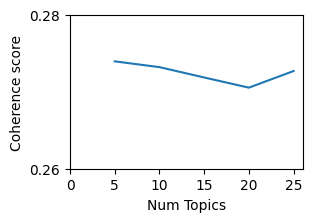

Num Topics = 5  has Coherence Value of 0.2739
Num Topics = 10  has Coherence Value of 0.2732
Num Topics = 15  has Coherence Value of 0.2718
Num Topics = 20  has Coherence Value of 0.2705
Num Topics = 25  has Coherence Value of 0.2727


In [11]:
# Print the coherence scores


# Show graph
limit=30; start=5; step=5;
x = np.arange(start,limit, step )
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks([0,5,10,15,20,25])
plt.yticks([0.26,0.28])
plt.show()

for m, cv in zip(x, coherence_values):
    print(f"Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [14]:
#finding the number of topics that gives the highest Coherence Value 
max_cv=max(coherence_values)
#finding the index of the model with this number of topics
index_model=coherence_values.index(max_cv)
# Select the model and print the topics 
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

2022-11-07 22:03:38,589 : INFO : topic #0 (0.067): 0.012*"united" + 0.011*"country" + 0.011*"international" + 0.011*"people" + 0.010*"nation" + 0.009*"state" + 0.008*"ha" + 0.007*"world" + 0.006*"would" + 0.006*"peace"
2022-11-07 22:03:38,590 : INFO : topic #1 (0.067): 0.017*"united" + 0.015*"nation" + 0.010*"ha" + 0.009*"international" + 0.008*"country" + 0.007*"world" + 0.007*"state" + 0.006*"people" + 0.006*"peace" + 0.005*"organization"
2022-11-07 22:03:38,590 : INFO : topic #2 (0.067): 0.016*"united" + 0.012*"ha" + 0.011*"nation" + 0.010*"country" + 0.009*"state" + 0.008*"international" + 0.008*"people" + 0.006*"organization" + 0.006*"development" + 0.006*"problem"
2022-11-07 22:03:38,591 : INFO : topic #3 (0.067): 0.015*"united" + 0.014*"country" + 0.011*"nation" + 0.010*"international" + 0.009*"ha" + 0.007*"world" + 0.007*"people" + 0.007*"state" + 0.006*"peace" + 0.005*"organization"
2022-11-07 22:03:38,592 : INFO : topic #4 (0.067): 0.017*"nation" + 0.015*"united" + 0.011*"sta

[(0, '0.012*"united" + 0.011*"country" + 0.011*"international" + 0.011*"people" + 0.010*"nation" + 0.009*"state" + 0.008*"ha" + 0.007*"world" + 0.006*"would" + 0.006*"peace"'), (1, '0.017*"united" + 0.015*"nation" + 0.010*"ha" + 0.009*"international" + 0.008*"country" + 0.007*"world" + 0.007*"state" + 0.006*"people" + 0.006*"peace" + 0.005*"organization"'), (2, '0.016*"united" + 0.012*"ha" + 0.011*"nation" + 0.010*"country" + 0.009*"state" + 0.008*"international" + 0.008*"people" + 0.006*"organization" + 0.006*"development" + 0.006*"problem"'), (3, '0.015*"united" + 0.014*"country" + 0.011*"nation" + 0.010*"international" + 0.009*"ha" + 0.007*"world" + 0.007*"people" + 0.007*"state" + 0.006*"peace" + 0.005*"organization"'), (4, '0.017*"nation" + 0.015*"united" + 0.011*"state" + 0.011*"ha" + 0.009*"international" + 0.009*"country" + 0.008*"people" + 0.007*"world" + 0.006*"organization" + 0.006*"peace"'), (5, '0.016*"nation" + 0.012*"united" + 0.012*"ha" + 0.010*"peace" + 0.009*"country"

In [17]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)
vis

/Users/lanchu/mambaforge/envs/legalbert/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/lanchu/mambaforge/envs/legalbert/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lanchu/mambaforge/envs/legalbert/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lanchu/mambaforge/envs/legalbert/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp imp

PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
10     0.008329  2.368486e-04       1        1  66.011453
4      0.001411  8.718127e-07       2        1  14.825476
2     -0.000245 -1.113716e-03       3        1   4.847071
5      0.000571 -2.055204e-04       4        1   4.684694
8      0.001276 -1.330471e-03       5        1   2.428165
7     -0.002575  4.423613e-03       6        1   2.415554
6     -0.000040  2.323401e-03       7        1   1.994340
9     -0.003603 -4.174858e-03       8        1   1.092207
0      0.001918 -1.172307e-03       9        1   0.643183
13    -0.000360 -2.368119e-03      10        1   0.508878
11    -0.000235  6.995682e-04      11        1   0.456492
3     -0.001285 -1.698194e-03      12        1   0.081950
12    -0.001144  3.837261e-03      13        1   0.003815
14     0.000013  4.846404e-04      14        1   0.003361
1     -0.004030  5.698078e-05      15        1   0.003361, topic_info=               Term         Freq        Total Category  logprob  loglift
790          nation  2699.000000  2699.000000  Default  30.0000  30.0000
566              ha  2371.000000  2371.000000  Default  29.0000  29.0000
1275         united  2049.000000  2049.000000  Default  28.0000  28.0000
871          people  2259.000000  2259.000000  Default  27.0000  27.0000
659   international  1824.000000  1824.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1345           year     0.025478  1023.011892  Topic15  -5.5761  -0.2998
785            must     0.021629   772.108820  Topic15  -5.7399  -0.1822
930         problem     0.023909  1035.063072  Topic15  -5.6397  -0.3751
548      government     0.023213  1003.532032  Topic15  -5.6692  -0.3737
344     development     0.024423  1304.514742  Topic15  -5.6184  -0.5852

[1370 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8358      1  0.812712       abdul
7492      1  0.843540   abounding
8359      1  0.769954  abridgment
8360      1  0.717569    accident
8501      1  0.808082  accounting
...     ...       ...         ...
1992      7  0.019182         yet
1992      8  0.009591         yet
1992      9  0.009591         yet
1992     10  0.009591         yet
1992     11  0.009591         yet

[3053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 3, 6, 9, 8, 7, 10, 1, 14, 12, 4, 13, 15, 2])